# Практика 2 часть 3. Многоклассовая логистическая регрессия (softmax) и градиентный спуск (без `sklearn`)

В этом ноутбуке мы **с нуля** реализуем многоклассовую логистическую регрессию (softmax-регрессию) для задачи классификации на несколько классов.

Мы будем использовать только `NumPy` и по шагам разберём:

1. **Softmax-функцию** как обобщение сигмоиды на случай $K$ классов.
2. **Вероятностную модель** многоклассовой логистической регрессии.
3. **Правдоподобие** для многоклассового случая и **кросс-энтропию** как функцию потерь.
4. **Градиент** softmax-регрессии и его матричную форму.
5. **Реализацию обучения** через градиентный спуск.
6. **Синтетический двумерный датасет** с тремя классами.
7. **Визуализации**:
   - убывание функции потерь и рост accuracy,
   - решающие области (decision regions) в пространстве $(x_1, x_2)$,
   - примеры распределения вероятностей по классам для отдельных объектов.

Во всём ноутбуке будем стараться держать баланс между **математической аккуратностью** и **интуитивными пояснениями**.


In [1]:
# Импорт необходимых библиотек

import numpy as np
import matplotlib.pyplot as plt

# Настройки визуализации
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['font.size'] = 12

# Фиксируем сид для воспроизводимости
np.random.seed(42)

## 1. Softmax-функция: обобщение сигмоиды на несколько классов

В бинарной логистической регрессии вероятность класса $1$ моделируется как

$$
p(y=1 \mid x) = \sigma(z) = \frac{1}{1 + e^{-z}},
$$

где $z = w^\top x$ — **линейная комбинация признаков**.

В многоклассовом случае, когда классов не два, а $K$ (например, $K=3$), мы хотим, чтобы модель возвращала **распределение вероятностей** по классам:

$$
p(y = k \mid x), \quad k = 1, 2, \dots, K,
$$

такое, что:

- $p(y = k \mid x) \ge 0$ для всех $k$,
- $\sum_{k=1}^K p(y = k \mid x) = 1$.

Т.е. функция будет возвращать вектор логитов:
$$
\mathbf{z} = (z_1, z_2, \dots, z_K)^\top
$$

Для этого используется **softmax-функция**.


### 1.1. Определение softmax

Для вектора логитов $\mathbf{z}$ softmax по компоненте $k$ определяется как

$$
p_k = \text{softmax}(\mathbf{z})_k = \frac{e^{z_k}}{\sum_{j=1}^K e^{z_j}}.
$$

Векторно:

$$
\mathbf{p} = \text{softmax}(\mathbf{z}), \quad \mathbf{p} \in (0,1)^K, \quad \sum_k p_k = 1.
$$

Интерпретация:

- $z_k$ можно понимать как «сырую оценку» или **скор** класса $k$,
- $e^{z_k}$ превращает скор в **неотрицательную величину**,
- деление на сумму нормирует значения в **полноценное распределение вероятностей**.

Замечание: при $K = 2$ softmax вырождается в сигмоиду (если смотреть на одну компоненту).


In [2]:
# Реализация численно устойчивого softmax

def softmax(logits):
    """
    logits: массив формы (n_samples, n_classes) или (n_classes,)
    Возвращает вероятности такой же формы.
    """
    logits = np.asarray(logits)
    if logits.ndim == 1:
        # Вектор логитов (один объект)
        c = np.max(logits)                 # вычитаем максимум для численной стабильности
        exp_shifted = np.exp(logits - c)
        return exp_shifted / np.sum(exp_shifted)
    else:
        # Матрица логитов (по объектам)
        c = np.max(logits, axis=1, keepdims=True)
        exp_shifted = np.exp(logits - c)
        return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)


# Демонстрация работы softmax на одном векторе логитов
z_example = np.array([1.0, 2.0, -0.5])
p_example = softmax(z_example)
print("Логиты:", z_example)
print("Softmax-вероятности:", p_example)
print("Сумма вероятностей:", np.sum(p_example))

Логиты: [ 1.   2.  -0.5]
Softmax-вероятности: [0.25371618 0.68967209 0.05661173]
Сумма вероятностей: 1.0000000000000002


### 1.2. Визуализация поведения softmax

Зафиксируем два логита $z_2$ и $z_3$, а третий логит $z_1$ будем менять.  
Посмотрим, как меняются вероятности трёх классов.

Пусть:

- $z_1 = t$ (переменная),
- $z_2 = 0$ (фиксирован),
- $z_3 = -1$ (фиксирован).

Интуитивно ожидаем, что при росте $t$ вероятность $p_1$ будет расти, а $p_2$ и $p_3$ — падать.


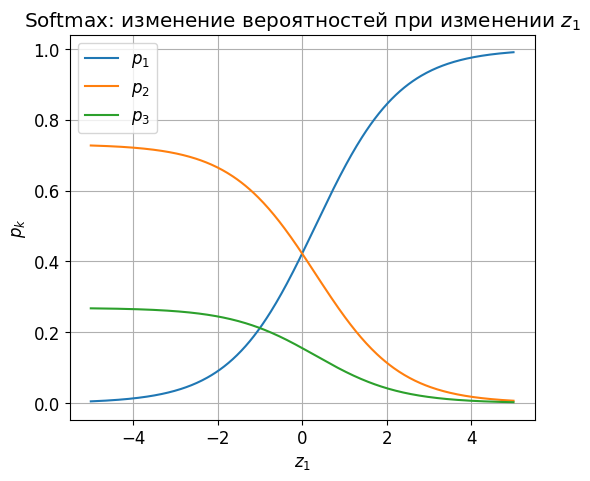

In [3]:
# Визуализация softmax при изменении одного логита

t_vals = np.linspace(-5, 5, 400)
p1_vals, p2_vals, p3_vals = [], [], []

for t in t_vals:
    z = np.array([t, 0.0, -1.0])
    p = softmax(z)
    p1_vals.append(p[0])
    p2_vals.append(p[1])
    p3_vals.append(p[2])

plt.plot(t_vals, p1_vals, label="$p_1$")
plt.plot(t_vals, p2_vals, label="$p_2$")
plt.plot(t_vals, p3_vals, label="$p_3$")
plt.xlabel("$z_1$")
plt.ylabel("$p_k$")
plt.title("Softmax: изменение вероятностей при изменении $z_1$")
plt.grid(True)
plt.legend()
plt.show()

## 2. Многоклассовая логистическая регрессия (softmax-регрессия)

В бинарной логистической регрессии мы использовали один вектор весов $w$ и скалярный логит $z = w^\top x$.

В многоклассовом случае (softmax-регрессии) делаем следующее:

- для **каждого класса** $k \in \{0, 1, \dots, K-1\}$ задаём **свой** вектор весов $w_k$,
- объединяем их в одну матрицу весов $W \in \mathbb{R}^{d \times K}$, где $d$ — число признаков (включая bias).

Тогда для объекта $x^{(i)}$ (вектор признаков длины $d$):

1. Вычисляем логиты для всех классов сразу:

$$
\mathbf{z}^{(i)} = W^\top x^{(i)} \in \mathbb{R}^K.
$$

2. Применяем softmax и получаем вероятности классов:

$$
\mathbf{p}^{(i)} = \text{softmax}(\mathbf{z}^{(i)}) \in (0,1)^K.
$$

Таким образом, модель задаёт распределение

$$
p(y^{(i)} = k \mid x^{(i)}) = p_k^{(i)}.
$$


### 2.1. One-hot кодирование меток

Метки $y^{(i)}$ в исходных данных — это целые числа от $0$ до $K-1$.  
Для удобства математических записей (правдоподобие, кросс-энтропия, градиент) удобно использовать **one-hot-представление** меток.

Пример для $K = 3$:

| Исходный класс $y$ | One-hot вектор $y_\text{onehot}$ |
|--------------------|-------------------------------------|
| 0                  | $[1, 0, 0]$                        |
| 1                  | $[0, 1, 0]$                        |
| 2                  | $[0, 0, 1]$                        |

Обозначения:

- $Y$ — матрица one-hot меток, размерность $(n, K)$,
- $P$ — матрица предсказанных вероятностей, размерность $(n, K)$.

Тогда $Y$ и $P$ удобно использовать в формуле функции потерь и в градиенте.


## 3. Правдоподобие и функция потерь (многоклассовая кросс-энтропия)

### 3.1. Вероятность правильной метки одного объекта

Рассмотрим объект $(x^{(i)}, y^{(i)})$.  
Модель даёт вектор вероятностей $\mathbf{p}^{(i)} = (p_1^{(i)}, \dots, p_K^{(i)})$.

Если истинный класс $y^{(i)} = k$, то **вероятность правильной метки** для этого объекта:

$$
p(y^{(i)} \mid x^{(i)}) = p_k^{(i)}.
$$

С использованием one-hot-вектора $y^{(i)}_\text{onehot} = (y_1^{(i)}, \dots, y_K^{(i)})$ эту же величину можно записать компактно:

$$
p(y^{(i)} \mid x^{(i)}) = \prod_{k=1}^K \bigl(p_k^{(i)}\bigr)^{y_k^{(i)}}.
$$

Работа этой формулы такая же, как в бинарном случае:

- если $y^{(i)}_k = 1$ для истинного класса, то берётся $p_k^{(i)}$,
- для остальных классов $y^{(i)}_j = 0$, и их вклад равен $1$.


### 3.2. Правдоподобие всей выборки

Пусть в выборке $n$ наблюдений, и мы предполагаем независимость объектов.  
Тогда **правдоподобие** всей выборки равно произведению вероятностей по объектам:

$$
\mathcal{L}(W) = \prod_{i=1}^n p(y^{(i)} \mid x^{(i)})
= \prod_{i=1}^n \prod_{k=1}^K \bigl(p_k^{(i)}\bigr)^{y_k^{(i)}}.
$$

Интуитивно это вероятность того, что:

> первый объект имеет свою метку **и** второй объект имеет свою метку **и** третий и т.д. — все $n$ меток одновременно совпадают с наблюдаемыми.


### 3.3. Лог-правдоподобие и функция потерь

Работать с произведением неудобно, поэтому берём логарифм:

$$
\log \mathcal{L}(W)
= \sum_{i=1}^n \sum_{k=1}^K y_k^{(i)} \log p_k^{(i)}.
$$

Максимизация лог-правдоподобия эквивалентна максимизации правдоподобия.  
В качестве функции потерь обычно используют **отрицательное усреднённое лог-правдоподобие**:

$$
L(W) = -\frac{1}{n} \sum_{i=1}^n \sum_{k=1}^K y_k^{(i)} \log p_k^{(i)}.
$$

Эта функция потерь называется **многоклассовой кросс-энтропией** (categorical cross-entropy).

Смысл:

- если модель даёт высокую вероятность истинному классу, вклад $-\log p_k^{(i)}$ мал,
- если модель уверенно ошибается (правильному классу даёт маленький $p$), потери сильно растут.


## 4. Градиент softmax-регрессии

Наша цель — получить компактную формулу для градиента $\nabla_W L(W)$, чтобы реализовать градиентный спуск.

Для одного объекта $i$ индивидуальная потеря:

$$
\ell^{(i)}(W) = - \sum_{k=1}^K y_k^{(i)} \log p_k^{(i)}.
$$

Через аккуратное применение правила цепочки (от $W$ к логитам $z$, затем к вероятностям $p$ и далее к $\ell$) можно показать, что

$$
\frac{\partial \ell^{(i)}}{\partial w_k} = \bigl(p_k^{(i)} - y_k^{(i)}\bigr) x^{(i)}.
$$

Здесь наблюдается очень естественная структура:

- $(p_k^{(i)} - y_k^{(i)})$ — **ошибка по вероятности** для класса $k$,
- $x^{(i)}$ — вектор признаков (как в линейной модели).

Суммируя по всем объектам и усредняя, получаем **матричную форму**:

$$
\nabla_W L(W) = \frac{1}{n} X^\top (P - Y),
$$

где

- $X \in \mathbb{R}^{n \times d}$ — матрица признаков,
- $P \in \mathbb{R}^{n \times K}$ — матрица вероятностей,
- $Y \in \mathbb{R}^{n \times K}$ — матрица one-hot меток.

Эта формула очень удобна для реализации на NumPy.


## 5. Синтетический датасет для трёх классов

Сгенерируем двумерные данные (два признака $x_1$ и $x_2$) для трёх классов.  
Каждый класс будет представлять собой гауссовское облако со своим центром и ковариацией.

Это позволит:

- визуально видеть данные на плоскости,
- рисовать решающие области softmax-регрессии.


Форма X_raw: (600, 2)
Форма y: (600,)


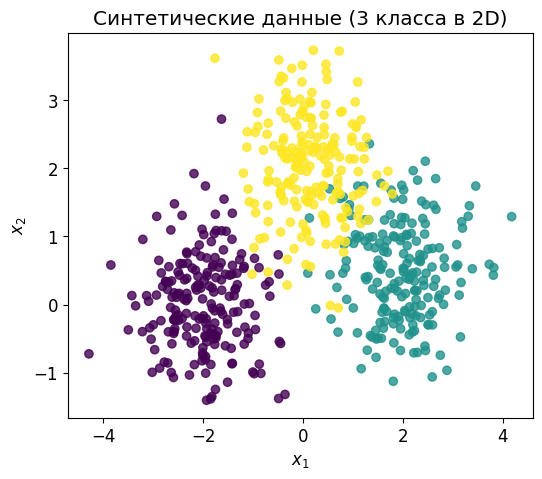

In [4]:
# Генерация синтетических данных (3 класса в 2D)

n_samples_per_class = 200

# Класс 0
mean0 = [-2.0, 0.0]
cov0 = [[0.5, 0.0],
        [0.0, 0.5]]
X0 = np.random.multivariate_normal(mean0, cov0, size=n_samples_per_class)
y0 = np.zeros(n_samples_per_class, dtype=int)

# Класс 1
mean1 = [2.0, 0.5]
cov1 = [[0.5, 0.0],
        [0.0, 0.5]]
X1 = np.random.multivariate_normal(mean1, cov1, size=n_samples_per_class)
y1 = np.ones(n_samples_per_class, dtype=int)

# Класс 2
mean2 = [0.0, 2.0]
cov2 = [[0.5, 0.0],
        [0.0, 0.5]]
X2 = np.random.multivariate_normal(mean2, cov2, size=n_samples_per_class)
y2 = np.full(n_samples_per_class, 2, dtype=int)

# Объединяем все классы
X_raw = np.vstack([X0, X1, X2])   # (n_samples, 2)
y = np.concatenate([y0, y1, y2])  # (n_samples,)

print("Форма X_raw:", X_raw.shape)
print("Форма y:", y.shape)

# Визуализируем точки
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, cmap="viridis", alpha=0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Синтетические данные (3 класса в 2D)")
plt.show()

### 5.1. Добавление bias-признака и one-hot-представления меток

Как и в линейной/логистической регрессии, удобно включить **свободный член** $w_0$ в модель.  
Для этого добавляем к признакам столбец единиц:

- исходно $X_\text{raw}$ имеет форму $(n, 2)$,
- после добавления bias-столбца получаем $X \in \mathbb{R}^{n \times 3}$,
  где первый столбец — единицы, остальные два — исходные признаки.

Также подготовим матрицу $Y$ с one-hot метками.


In [5]:
n_samples = X_raw.shape[0]
n_classes = len(np.unique(y))

# Добавляем bias-столбец: первый столбец = 1
X = np.hstack([np.ones((n_samples, 1)), X_raw])  # (n_samples, d), d = 3

# One-hot метки
Y = np.zeros((n_samples, n_classes))
Y[np.arange(n_samples), y] = 1.0

print("Форма X (с bias):", X.shape)
print("Форма Y (one-hot):", Y.shape)
print("Число классов:", n_classes)

Форма X (с bias): (600, 3)
Форма Y (one-hot): (600, 3)
Число классов: 3


## 6. Прямой проход модели, функция потерь и accuracy

Теперь реализуем базовые строительные блоки модели:

1. `forward_softmax(X, W)` — считает:
   - логиты $Z = X W$,
   - вероятности $P = \text{softmax}(Z)$.

2. `multiclass_cross_entropy(Y_true, P_pred)` — многоклассовая кросс-энтропия (усреднённая по объектам).

3. `accuracy_score_multiclass(y_true, P_pred)` — доля правильных предсказаний.

Все эти функции будут использоваться в цикле градиентного спуска.


In [6]:
def forward_softmax(X, W):
    """
    Прямой проход softmax-регрессии.

    X: (n_samples, n_features)
    W: (n_features, n_classes)

    Возвращает:
    Z: (n_samples, n_classes) - логиты
    P: (n_samples, n_classes) - вероятности классов
    """
    Z = X @ W
    P = softmax(Z)
    return Z, P


def multiclass_cross_entropy(Y_true, P_pred):
    """
    Многоклассовая кросс-энтропия (усреднённая по объектам).

    Y_true: (n_samples, n_classes) - one-hot метки
    P_pred: (n_samples, n_classes) - вероятности классов
    """
    eps = 1e-9                     # защита от log(0)
    P_pred = np.clip(P_pred, eps, 1 - eps)
    loss = -np.sum(Y_true * np.log(P_pred)) / Y_true.shape[0]
    return loss


def accuracy_score_multiclass(y_true, P_pred):
    """
    Accuracy = доля правильных предсказаний.

    y_true: (n_samples,) - истинные метки 0..K-1
    P_pred: (n_samples, n_classes) - вероятности
    """
    y_pred = np.argmax(P_pred, axis=1)
    return np.mean(y_true == y_pred)

## 7. Обучение softmax-регрессии градиентным спуском

Используем ранее выведенную формулу градиента:

$$
\nabla_W L(W) = \frac{1}{n} X^\top (P - Y).
$$

Алгоритм градиентного спуска для softmax-регрессии:

1. Инициализируем матрицу весов $W$ (например, нулями).
2. Для каждой эпохи:
   - считаем логиты $Z$ и вероятности $P$,
   - считаем loss = кросс-энтропию,
   - считаем accuracy,
   - считаем градиент $\nabla_W L(W)$,
   - делаем шаг обновления: $W \leftarrow W - \eta \nabla_W L(W)$,
   - сохраняем историю для последующей визуализации.


In [7]:
def compute_gradient_softmax(X, Y_true, P_pred):
    """
    Вычисление градиента кросс-энтропии по параметрам W.

    X: (n_samples, n_features)
    Y_true: (n_samples, n_classes)
    P_pred: (n_samples, n_classes)
    """
    n_samples = X.shape[0]
    grad_W = X.T @ (P_pred - Y_true) / n_samples
    return grad_W


def train_softmax_regression_gd(X, Y, y_labels, lr=0.1, n_epochs=200):
    """
    Обучение softmax-регрессии градиентным спуском.

    X: (n_samples, n_features)
    Y: (n_samples, n_classes) - one-hot метки
    y_labels: (n_samples,) - метки 0..K-1 (для accuracy)
    lr: шаг обучения
    n_epochs: количество эпох

    Возвращает:
    W_history: список матриц W (по эпохам)
    loss_history: список значений функции потерь
    acc_history: список значений accuracy
    """
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]

    # Инициализируем веса нулями
    W = np.zeros((n_features, n_classes))

    W_history = []
    loss_history = []
    acc_history = []

    for epoch in range(n_epochs):
        # Прямой проход
        Z, P = forward_softmax(X, W)

        # Функция потерь и accuracy
        loss = multiclass_cross_entropy(Y, P)
        acc = accuracy_score_multiclass(y_labels, P)

        # Градиент
        grad_W = compute_gradient_softmax(X, Y, P)

        # Шаг градиентного спуска
        W = W - lr * grad_W

        # Логирование
        W_history.append(W.copy())
        loss_history.append(loss)
        acc_history.append(acc)

        if (epoch + 1) % 20 == 0:
            print(f"Эпоха {epoch+1:4d} | Loss = {loss:.4f} | Accuracy = {acc:.4f}")

    return np.array(W_history), np.array(loss_history), np.array(acc_history)

In [8]:
# Обучаем softmax-регрессию на синтетическом датасете

lr = 0.1
n_epochs = 200

W_history, loss_history, acc_history = train_softmax_regression_gd(
    X, Y, y, lr=lr, n_epochs=n_epochs
)

W_final = W_history[-1]
print("\nИтоговая матрица W имеет форму:", W_final.shape)

Эпоха   20 | Loss = 0.4120 | Accuracy = 0.9533
Эпоха   40 | Loss = 0.2940 | Accuracy = 0.9533
Эпоха   60 | Loss = 0.2459 | Accuracy = 0.9533
Эпоха   80 | Loss = 0.2192 | Accuracy = 0.9533
Эпоха  100 | Loss = 0.2021 | Accuracy = 0.9533
Эпоха  120 | Loss = 0.1900 | Accuracy = 0.9533
Эпоха  140 | Loss = 0.1810 | Accuracy = 0.9533
Эпоха  160 | Loss = 0.1740 | Accuracy = 0.9550
Эпоха  180 | Loss = 0.1684 | Accuracy = 0.9550
Эпоха  200 | Loss = 0.1638 | Accuracy = 0.9533

Итоговая матрица W имеет форму: (3, 3)


### 7.1. Динамика функции потерь и accuracy

Построим графики:

- кросс-энтропии $L(W)$ по эпохам,
- accuracy по эпохам.

Ожидаем, что при разумном шаге обучения:

- loss **убывает** или хотя бы стабилизируется,
- accuracy **растёт** и выходит на плато.


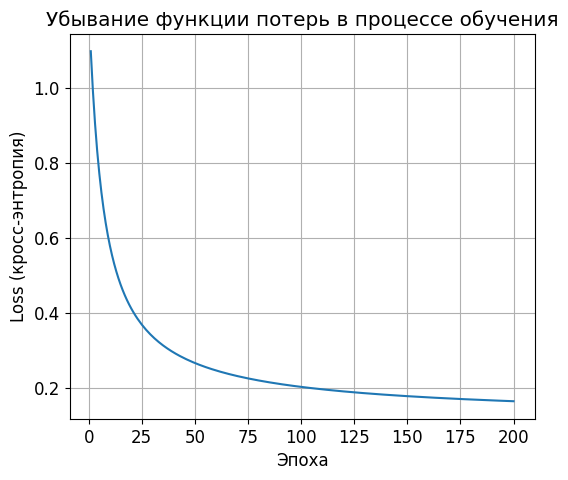

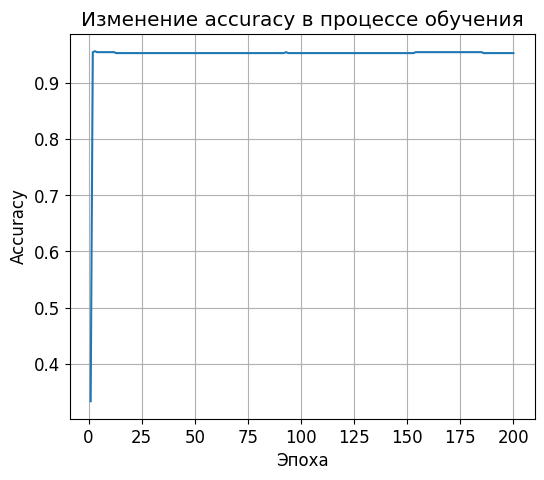

In [9]:
epochs = np.arange(1, len(loss_history) + 1)

plt.plot(epochs, loss_history)
plt.xlabel("Эпоха")
plt.ylabel("Loss (кросс-энтропия)")
plt.title("Убывание функции потерь в процессе обучения")
plt.grid(True)
plt.show()

plt.plot(epochs, acc_history)
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Изменение accuracy в процессе обучения")
plt.grid(True)
plt.show()

## 8. Визуализация решающих областей (decision regions)

Одно из преимуществ двумерных синтетических данных — возможность **визуализировать, как модель разделяет пространство признаков**.

Подход:

1. Строим прямоугольную сетку по $x_1$ и $x_2$.
2. Для каждой точки сетки считаем вероятности классов через текущую модель.
3. Берём класс с максимальной вероятностью — это предсказанный класс.
4. Раскрашиваем точки сетки по предсказанному классу (получаем цветные области).
5. Сверху рисуем реальные точки выборки.

Так можно увидеть:

- где модель проводит границы между классами,
- насколько эти границы разумны относительно исходных данных.


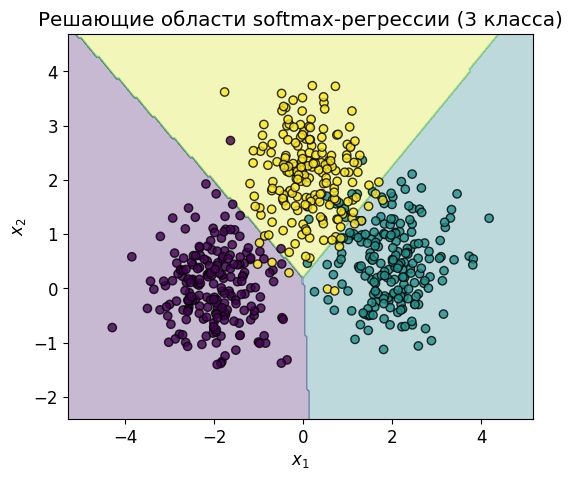

In [10]:
def plot_decision_regions_softmax(X_raw, y, W, title=None, grid_step=0.05):
    # Границы по осям
    x1_min, x1_max = X_raw[:, 0].min() - 1.0, X_raw[:, 0].max() + 1.0
    x2_min, x2_max = X_raw[:, 1].min() - 1.0, X_raw[:, 1].max() + 1.0

    # Строим сетку
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, grid_step),
        np.arange(x2_min, x2_max, grid_step)
    )

    # Собираем точки сетки в матрицу признаков
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]          # (N_grid, 2)
    grid_X = np.hstack([np.ones((grid_points.shape[0], 1)), grid_points])  # добавляем bias

    # Предсказываем вероятности и классы
    _, P_grid = forward_softmax(grid_X, W)
    y_grid = np.argmax(P_grid, axis=1).reshape(xx1.shape)

    # Рисуем решающие области и исходные точки
    plt.contourf(xx1, xx2, y_grid, alpha=0.3, cmap="viridis")
    plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, cmap="viridis", edgecolor="k", alpha=0.8)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if title is not None:
        plt.title(title)
    plt.show()


plot_decision_regions_softmax(X_raw, y, W_final, title="Решающие области softmax-регрессии (3 класса)")

## 9. Примеры распределения вероятностей по классам

Чтобы понять, насколько «уверенно» модель делает предсказания, полезно посмотреть не только на итоговый класс, но и на **распределение вероятностей** по всем классам.

Сделаем следующее:

- выберем несколько случайных объектов из выборки,
- выведем их координаты $(x_1, x_2)$,
- выведем истинный класс,
- выведем предсказанные вероятности $p_0, p_1, p_2$,
- выведем предсказанный класс (аргмакс).

Это даёт интуицию о том, как модель «сомневается» на границах между классами и насколько уверена внутри кластера.


In [11]:
# Распределение вероятностей для нескольких случайных объектов

_, P_final = forward_softmax(X, W_final)

idx_sample = np.random.choice(n_samples, size=5, replace=False)

for idx in idx_sample:
    print(f"Объект #{idx}: x = {X_raw[idx]}, истинный класс = {y[idx]}")
    print("Предсказанные вероятности классов:", P_final[idx])
    print("Предсказанный класс:", np.argmax(P_final[idx]))
    print("-")

Объект #183: x = [-1.84154269  0.00890417], истинный класс = 0
Предсказанные вероятности классов: [0.96942354 0.00149664 0.02907981]
Предсказанный класс: 0
-
Объект #598: x = [-0.01388602  2.39066939], истинный класс = 2
Предсказанные вероятности классов: [0.01452561 0.0202389  0.96523549]
Предсказанный класс: 2
-
Объект #161: x = [-2.57856939  1.47954123], истинный класс = 0
Предсказанные вероятности классов: [8.71995754e-01 1.33152662e-04 1.27871093e-01]
Предсказанный класс: 0
-
Объект #490: x = [0.55564462 2.30084393], истинный класс = 2
Предсказанные вероятности классов: [0.00632686 0.06341526 0.93025788]
Предсказанный класс: 2
-
Объект #211: x = [1.82395576 1.18700441], истинный класс = 1
Предсказанные вероятности классов: [0.0011918 0.8227781 0.1760301]
Предсказанный класс: 1
-


## 10. Итоговые выводы

В этом ноутбуке мы пошагово построили и исследовали многоклассовую логистическую регрессию (softmax-регрессию):

1. Ввели **softmax-функцию** как обобщение сигмоиды на $K$ классов и увидели, как она превращает логиты в распределение вероятностей.
2. Построили **вероятностную модель**: каждый класс имеет свой вектор весов, а модель возвращает $p(y = k \mid x)$.
3. Записали **правдоподобие** для многоклассового случая и получили **многоклассовую кросс-энтропию** как отрицательное лог-правдоподобие.
4. Вывели и использовали компактную формулу градиента:

$$
\nabla_W L(W) = \frac{1}{n} X^\top (P - Y).
$$

5. Реализовали обучение softmax-регрессии через **градиентный спуск**, отслеживая историю потерь и точности.
6. Сгенерировали и визуализировали **синтетический трёхклассовый датасет** в двумерном пространстве признаков.
7. Построили:
   - графики убывания функции потерь и роста accuracy,
   - **решающие области** на плоскости $(x_1, x_2)$,
   - примеры распределений вероятностей по классам для отдельных объектов.

Дальнейшие естественные шаги:

- добавить **регуляризацию** (L2, L1) и посмотреть, как она влияет на границы,
- сравнить с `LogisticRegression(multi_class='multinomial')` из `sklearn`,
- ввести **многоклассовые метрики** (macro-F1, weighted-F1 и др.) и применить их к этой же задаче.
